# Frame sums and XGM

In this tutorial, we show how to reduce raw data in order to obtain the sum of all pixels for each frame in the run as well as the XGM (per frame) values.

We start by importing the modules we are going to use:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import euxfel_scs_tools as scs

In [3]:
import xarray as xr
xr.set_options(display_style='text')

In the following cell, we define run-specific information:

In [4]:
proposal = 2530  # proposal number
run = 50  # run number
dark_run = 49
pattern = ['image', 'dark'] * 99 + ['endimage']  # the pattern of frames in each train
dirname = 'processed_runs_xgm'  # directory where we are going to save processed data

The length of `pattern` list must be the same as the number of frames per train. `dirname` can be any path, but in the case of reducing data, the resulting files cannot be written if you do not have writing priviledges in that directory. Accordingly, it is most safe to keep all files you process in your user directory.

## Data reduction

From the notebook `scs.reduction_sum` can be called. This function is going to submit 16 jobs to the queue (one per DSSC module). Function's signature is:

```
scs.reduction_sum(proposal, run, pattern, frame_type=None, trains=None, njobs=40, dirname=None)
```

The individual arguments are:

- `proposal` - proposal number
- `run` - run number
- `pattern` - the pattern of frames in each train
- `frame_type` - type of frames that are reduced. This must be one of the frame names from `pattern` and XGM data must have been saved for that frame (non-dark frames).
- `trains` - the list of trains whose frames are reduced. It defaults to `None` and all trains in the run will be summed.
- `njobs` - the number of jobs executed on each node
- `dirname` - directory name where reduced files are going to be saved

Let us say we want to reduce all image-frames and extract XGM values for all of them. The function call is:

In [5]:
scs.reduction_sum(proposal=proposal, run=run, pattern=pattern, frame_type='image', dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


In [5]:
scs.reduction_std(proposal=proposal, run=dark_run, pattern=pattern, dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


In [7]:
scs.reduction_std(proposal=proposal, run=run, pattern=pattern, dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


# "Normalised" run

In [57]:
scs.reduction_sum_norm(proposal=proposal, run=run, pattern=pattern, dark_run=dark_run, dirname=dirname,
                       frames={'image': 'image',
                               'dark': 'dark'},
                       dark_run_frames={'image': 'image',
                                        'dark': 'dark'},
                       trains=None, njobs=40)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


After some time (in my case 1 min), all jobs are completed and in `dirname` directory `run_50` is created. Inside that directory, 16 `.h5` files are created with names `module_NUM_sum.h5`, where `NUM` is the module number (0, 1, 2,... 15). In each HDF5 file, two arrays are saved:

- `FRAME_TYPE_sum`, where `FRAME_TYPE` is what we passed as `frame_type` previously.
- `xgm`, where "per-frame" XGM data is saved

In addition, two more directories are created:

- `slurm_log`, where all `.out` files are saved
- `autogenerated_scripts`, where all scripts for individual nodes are saved

These directories are used for debugging only and can be deleted.

## Reduced data reading

In order to read all previously created files and combine them into `xarray`, `scs.read` function can be called. Its signature is:

```
scs.read(dirname, run, reduction_type, data)
```

The individual arguments are:

- `dirname` - directory name where reduced files were saved
- `run` - run number
- `reduction_type` - this is the type of reduced data read. In our case, we use `sum`.
- `data` - data to be read from an HDF5 file. Because we summed image frames, this is going to be `image_sum`.

Let us read the data now:

In [7]:
image_sum, xgm = scs.read(dirname=dirname, run=run, reduction_type='sum', dataset='image_sum')

In [58]:
image_norm_sum, xgm = scs.read(dirname=dirname, run=run, reduction_type='sum_norm', dataset='image_sum')

In [9]:
image_norm_sum.shape

(16, 597762)

In [10]:
image_sum.shape

(16, 597762)

In [11]:
dark_image = scs.read(dirname=dirname, run=dark_run, reduction_type='std', dataset='image_std')
dark_intradark = scs.read(dirname=dirname, run=dark_run, reduction_type='std', dataset='dark_std')

image_intradark = scs.read(dirname=dirname, run=run, reduction_type='std', dataset='dark_std')

In [12]:
dark_intradark.shape

(99, 16, 128, 512)

In [13]:
dark_image_avg = np.sum(dark_image, axis=(1,2,3))
dark_intradark_avg = np.mean(np.sum(dark_intradark, axis=(1,2,3)), axis=0)
image_intradark_avg = np.mean(np.sum(image_intradark, axis=(1,2,3)), axis=0)

full_dark_avg = (image_intradark_avg + dark_image_avg - dark_intradark_avg)

In [14]:
dark_image_pulse_avg = np.sum(dark_image, axis=(1, 2, 3))

#### Sum without normalisation

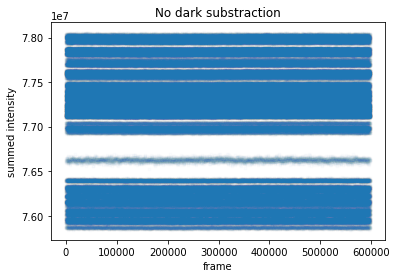

In [63]:
sum_simple = np.sum(image_sum, axis=0)
plt.plot(sum_simple, '.', alpha=0.01);
plt.title('No dark substraction')
plt.xlabel('frame')
plt.ylabel('summed intensity')
#plt.savefig('no_dark_substracted.png', dpi=300)

#### Sum with dark_image normalisation
Averaging only over trains

585.8637488830063


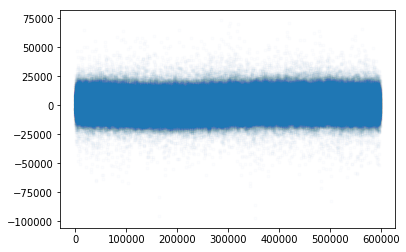

In [53]:
sum_dark_avg = (np.sum(image_sum, axis=0).data.reshape(-1,99)
                   - dark_image_pulse_avg.data.reshape(-1, 99)).reshape(-1)
plt.plot(sum_dark_avg, '.', alpha=0.01);
print(np.mean(sum_dark_avg))

#### Sum with full dark normalisation
dark_darks averaged over trains; image_intradarks and dark_intradarks averaged over trains and pulses

1273.2760644757784


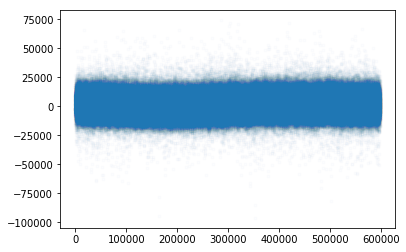

In [52]:
sum_full_avg = (np.sum(image_sum, axis=0).data.reshape(-1,99) - full_dark_avg.data.reshape(-1,99)).reshape(-1)
plt.plot(sum_full_avg, '.', alpha=0.01);
print(np.mean(sum_full_avg))

dark_darks averaged over trains **and pulses**; image_intradarks and dark_intradarks averaged over trains and pulses

<xarray.DataArray ()>
array(1273.27606448)


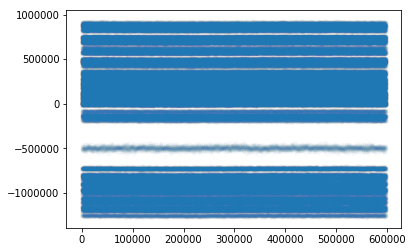

In [51]:
sum_full_avg = np.sum(image_sum, axis=0) - np.mean(full_dark_avg.data.reshape(-1,99))
plt.plot(sum_full_avg, '.', alpha=0.01);
print(np.mean(sum_full_avg))

#### Sum without normalisation

<xarray.DataArray ()>
array(1273.31036741)


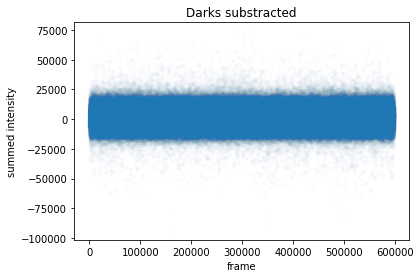

In [64]:
sum_norm = np.sum(image_norm_sum, axis=0)
plt.plot(sum_norm, '.', alpha=0.01);
plt.xlabel('frame')
plt.ylabel('summed intensity')
plt.title('Darks substracted')
print(np.mean(sum_norm))
#plt.savefig('dark_substracted.png', dpi=300)

Effect of train-resolved intradarks compared to averaged intradarks.

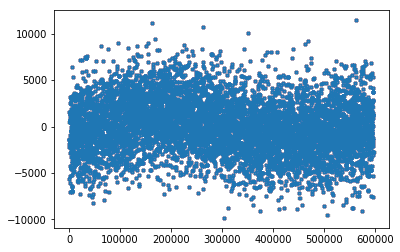

In [54]:
plt.plot((sum_norm - sum_full_avg), '.', alpha=0.01)

---

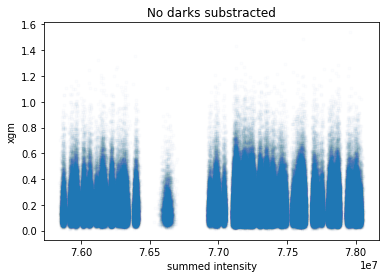

In [66]:
plt.plot(sum_simple, xgm, '.', alpha=0.01)
plt.xlabel('summed intensity')
plt.ylabel('xgm');
plt.title('No darks substracted')
#plt.savefig('xgm_intesity.png', dpi=300)

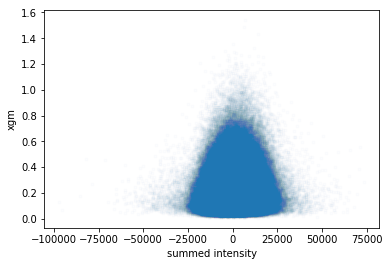

In [22]:
plt.plot(sum_dark_avg, xgm, '.', alpha=0.01)
plt.xlabel('summed intensity')
plt.ylabel('xgm');

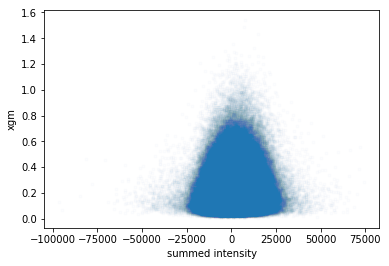

In [56]:
plt.plot(sum_full_avg, xgm, '.', alpha=0.01)
plt.xlabel('summed intensity')
plt.ylabel('xgm');

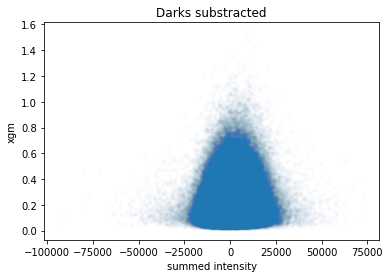

In [67]:
plt.plot(sum_norm, xgm, '.', alpha=0.01)
plt.xlabel('summed intensity')
plt.ylabel('xgm');
plt.title('Darks substracted')
#plt.savefig('xgm_intensity_dark.png', dpi=300)